# Natural Language Processing with Disaster Tweets

## 1.Load Data & Libraries

In [1]:
import re                                                 # Regex for string extraction
import spacy                                              # Spacy for text processing
import string                                             # For using string functions and properties
import numpy as np                                        # Linear Algebra
import pandas as pd                                       # Pandas for DataFrame
import seaborn as sns                                     # Sns for plots
from scipy import stats
from matplotlib import pyplot as plt                      # Matplotlib for plots
from wordcloud import WordCloud                           # Wordclouds

# Keras packages
from keras.preprocessing.text import Tokenizer            # Simplifies different tokenizing methods
from keras.utils.vis_utils import plot_model              # For plotting model
from keras.models import Sequential                       # Sequential model
from keras.layers import Dense                            # Dense layer

nlp = spacy.load('en_core_web_sm')  # Load the English language (Other options: en_core_web_md, en_core_web_lg)

In [2]:
# Load original data
train_df = pd.read_csv('../input/nlp-getting-started/train.csv')
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')

# Combine original data for easier manipulating them later
combined = [train_df, test_df]

# Take a leak at the original data
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


I'll also load an external dataset to help speedup city and country extraction:

In [3]:
# Load cities data
cities_df = pd.read_csv('../input/world-cities/worldcities.csv')
cities_df['city'] = cities_df['city'].apply(lambda x: x.lower())

# Get a list of cities
cities = list(cities_df['city'])

# Create country_df
countries_df = cities_df[['iso2', 'iso3', 'country']].groupby(by = 'country', as_index = False).max()
countries_df.dropna(axis = 0, inplace = True)                                 # Drop NAs
countries_df['iso2'] = countries_df['iso2'].apply(lambda x: x.lower())
iso2 = list(countries_df['iso2'])

In [4]:
# Print basic properties
print(f"Training Data has {train_df.shape[0]} rows and {train_df.shape[1]} columns: ({list(train_df.columns)})")
print(f"Testing Data has {test_df.shape[0]} rows and {test_df.shape[1]} columns: ({list(test_df.columns)})")

Training Data has 7613 rows and 5 columns: (['id', 'keyword', 'location', 'text', 'target'])
Testing Data has 3263 rows and 4 columns: (['id', 'keyword', 'location', 'text'])


## 2.Exploratory Data Analysis (EDA)
Let's analyze different features of our datasets to identity abnormalities and their behaviors. We will do the followings:
- Check the distribution of our target variable, **target**.
- Investigate the **Location** feature and check its usefulness and possible features we can extract from it.
- Investigate how helpful the **Keyword** feature is and how that can be used in the model.
- Go through the **Text** features and identify problems and possible fixes. Also look for possible features that can be extracted and analyzed later on.

### 2.1.Target feature distrubution

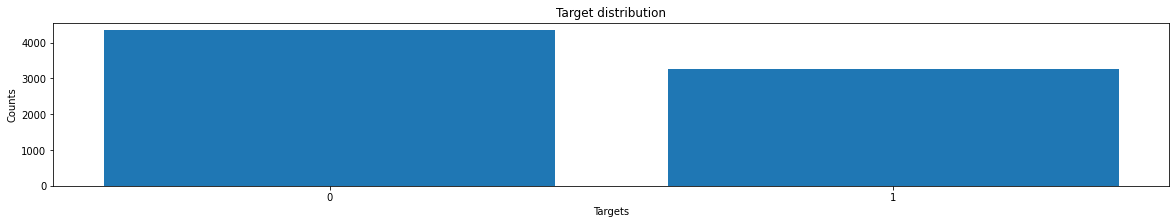

In [5]:
# Check the distribution of tagets
target_counts = train_df['target'].value_counts()

fig = plt.figure(figsize = (20, 3))
plt.title('Target distribution')
plt.xlabel('Targets')
plt.ylabel('Counts')
plt.xticks([0, 1])
plt.bar(target_counts.keys(), target_counts.values)
plt.show()

Looking at the distribution, I say it's OK. It's not evenly balanced and that can be something we might want to fix by downcasting the data later when optimizing the model. Downcasting may or may not be a good idea as we loose some of our data! (You have to test it to find out its impact on the model)

### 2.2.Location feature

#### 2.2.1Analysis

In [6]:
# NULL entries
null_entries = train_df.loc[train_df['location'].isnull()]
null_entries_count = len(null_entries)
print(f'- There are {null_entries_count} missing entries on "location" column ({round(null_entries_count / train_df.shape[0] * 100, 1)}%)')

# Uniqueness
unique_locations = train_df['location'].unique()
unique_locations_count = len(unique_locations)
print(f'- Number of unique locations: {unique_locations_count} ({round(unique_locations_count/train_df.shape[0]*100, 2)}%)')

- There are 2533 missing entries on "location" column (33.3%)
- Number of unique locations: 3342 (43.9%)


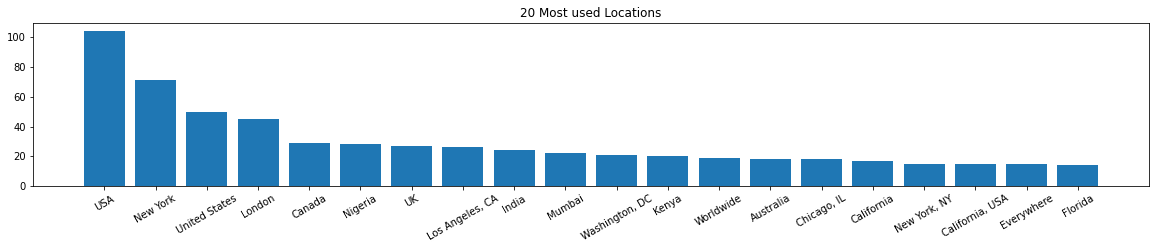

In [7]:
# 20 Top Frequencies
location_freq = train_df['location'].value_counts()
top_20_locs = location_freq[:20]

fig = plt.figure(figsize = (20, 3))
plt.title('20 Most used Locations')
plt.bar(top_20_locs.index, top_20_locs.values)
plt.xticks(rotation = 30)
plt.show()

After a careful investigation of the **location** feature, I found some interesting facts:
- About 33% of the entries are missing. Questions: *Why? Are they really missing or ther is a relation to disaster tweets?*
- About 44% of the entried are unique. Question: *Are tweets focused around spesific areas? Or we just ran out of cities?*
- There are lots of problems in the entries, for instance:
    - Some entries only contain numbers, like *304* or *404* (These are familiar if you have done web-dev)
    - Some entries contain [Geographic coordinate system](https://en.wikipedia.org/wiki/Geographic_coordinate_system).
    - Some entries contain dates, times and months.
    - Many entries aren't relevant to location at all. This is because some people write random stuff in their location field. We can use the fact that many locations are not actually locations, feature engineer them into a new binary columns **is_relevant** and check if that gives us a good feature to work with.
    - Many countries are in [iso code](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes), if we are using models like Google's Word2Vec or GloVe, this can be problematic. To fix it I'll use an external dataset.
    - Some entities contains *#hashtags*, *@mentions* and *:links*. We can extract them as well.

So this is going to be a 2-step process: Cleanup and patchup, then feature Engineering. But first let's write some functions to help us along the way:

#### 2.2.2.Cleanup, Patchup and Feature Extraction

In [8]:
# Remove URLs
def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# Remove HTML
def remove_html(text):
    return re.sub(r'<.*?>', '', text)

# Converts text to lowercase
def to_lower(text):
    return text.lower()

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Remove mentions
def remove_mentions(text):
    return re.sub(r'@\w*', '', text)

# Remove hashtags
def remove_hashtags(text):
    return re.sub(r'#\w*', '', text)

# Remove links
def remove_links(text):
    return re.sub(r'\bhttps?://\S+', '', text)

# Remove emojis
def remove_emojis(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
    "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

# Remove non-ASCII characters
def remove_non_ascii(text):
#     return ''.join(filter(lambda x: x in string.printable, text))
    return text.encode("ascii",errors="ignore").decode()

# Lemmatize text
def lemmatize_text(text):
    return ' '.join([token.lemma_ for token in nlp(text)])

# Remove stopwords
def remove_stopwords(text):
    return ' '.join([token.text for token in nlp(text) if not token.is_stop])

# Remove punctuation
def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def convert_spacing_encode(text):
    return text.replace('%20', ' ')

# Remove white space (Extra step, just in case)
def remove_whitespace(text):
    return ' '.join(text.split())

# Filter out words with too few characters (2 by default)
def filter_words(text):
    return ' '.join([word for word in text.split() if len(word) > 2])

In [9]:
# Extract hashtags in form of #<str> (They must have atleast 3 characters)
def extract_hashtags(text):
    matches = re.findall(r'#\w*', text)
    return [match[1:].lower() for match in matches if len(match) > 2] if matches != [] else np.nan

# Extract mentions in form of @<str> (They must have atleast 3 characters)
def extract_mentions(text):
    matches = re.findall(r'@\w*', text)
    return [match[1:].lower() for match in matches if len(match) > 2] if matches != [] else np.nan

# Extract links
def extract_links(text):
    matches = re.findall(r'\bhttps?://\S+', text)
    return matches if matches != [] else np.nan

# Extract cities
def extract_city(text):
    clean_text = remove_punctuation(text)
    _cities = list([word.capitalize() for word in clean_text.split() if word in cities])
    return _cities[0] if _cities != [] else np.nan

# Extract countries
def extract_country(text):
    clean_text = remove_punctuation(text)
    _countries = [countries_df.loc[countries_df['iso2'] == word, 'country'].values[0] for word in clean_text.split() if word in iso2]  
    return _countries[0] if _countries != [] else np.nan

In [10]:
# Conditions for train & test data
loc_not_na = [train_df['location'].notnull(), test_df['location'].notnull()]


for i, df in enumerate(combined):
    con = loc_not_na[i]
    
    # Convert to lower
    df.loc[con, 'location'] = df.loc[con, 'location'].apply(to_lower)

    # Remove Non-ASCII
    df.loc[con, 'location'] = df.loc[con, 'location'].apply(remove_non_ascii)
    
    # Feature Extract #hashtags, @mentions and :links
    df.loc[con, 'location_hashtags'] = df.loc[con, 'location'].apply(extract_hashtags)
    df.loc[con, 'location_mentions'] = df.loc[con, 'location'].apply(extract_mentions)
    df.loc[con, 'location_links'] = df.loc[con, 'location'].apply(extract_links)

    # Feature Extract countries and cities
    df['city'] = np.nan
    df['country'] = np.nan
    df.loc[con, 'city'] = df.loc[con, 'location'].apply(extract_city)
    df.loc[con, 'country'] = df.loc[con, 'location'].apply(extract_country)

    # Feature Extract
    df['has_location'] = 0
    df.loc[(df['city'].notnull()) | (df['country'].notnull()), 'has_location'] = 1

By now, we have some extracted some new features from **location** and what's left, I think is not very useful (We could remove it, but patience):
- location_hashtags
- location_mentions
- location_links
- country
- city

### 2.3.Keyword feature

#### 2.3.1.Analysis

In [11]:
# NULL entries
null_entries = train_df.loc[train_df['keyword'].isnull()]
null_entries_count = len(null_entries)
print(f'- There are {null_entries_count} missing entries on "keyword" column ({round(null_entries_count / train_df.shape[0] * 100, 2)}%)')

# Uniqueness
unique_locations = train_df['keyword'].unique()
unique_locations_count = len(unique_locations)
print(f'- Number of unique keyword: {unique_locations_count} ({round(unique_locations_count/train_df.shape[0]*100, 2)}%)')

- There are 61 missing entries on "keyword" column (0.8%)
- Number of unique keyword: 222 (2.92%)


By analyzing the results and taking a quick look at the data itself, I found:
- There are only 8 missing entries (less than 1%) which we can take care of by imputing them.
- Only 222 unique keywords exist (~3%) which might be too good or too bad for us, We'll see..
- Looking at the 25 most frequently used keywords, they are mostly about disasters (more than 80% of top 25 keywords)
- Keywords must be lemmatized. (For instance we have both *sinking* and *sunk*)

#### 2.3.2.Feature Engineering

In [12]:
for df in combined:
    keyword_not_na = df['keyword'].notnull()
    
    # Lemmatize
    df.loc[keyword_not_na, 'keyword'] = df.loc[keyword_not_na, 'keyword'].apply(lemmatize_text)
    
    # Fix space encoding    
    df.loc[keyword_not_na, 'keyword'] = df.loc[keyword_not_na, 'keyword'].apply(convert_spacing_encode)

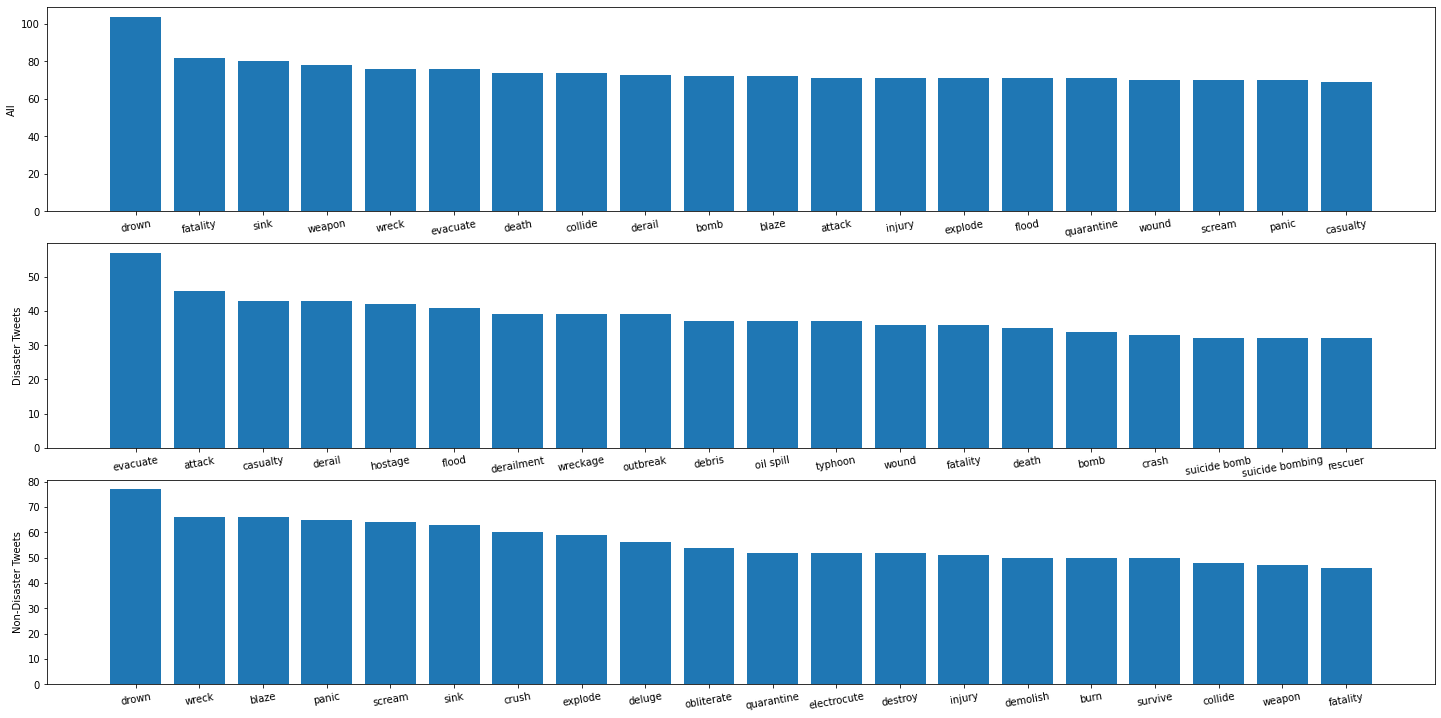

In [13]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (20, 10))
fig.tight_layout()

# All
keyword_freq = train_df['keyword'].value_counts()
axs[0].set_ylabel('All')
axs[0].bar(keyword_freq[:20].index, keyword_freq[:20].values)

# target == 1
keyword_freq = train_df.loc[train_df['target'] == 1, 'keyword'].value_counts()
axs[1].set_ylabel('Disaster Tweets')
axs[1].bar(keyword_freq[:20].index, keyword_freq[:20].values)

# target == 0
keyword_freq = train_df.loc[train_df['target'] == 0, 'keyword'].value_counts()
axs[2].set_ylabel('Non-Disaster Tweets')
axs[2].bar(keyword_freq[:20].index, keyword_freq[:20].values)

# Rotate axis
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation = 10)

plt.show()

#### 2.3.3.More Analysis

In [14]:
# Get unique keywords
keywords = train_df.loc[train_df['keyword'].notnull(), 'keyword'].unique()

# Create keywords dataframe
keywords_df = pd.DataFrame(data = {'keyword': keywords})

disaster_cnts, total_cnts = [], []
disaster_probs = []
for i, row in keywords_df.iterrows():

    tmp_df = train_df.loc[(train_df['keyword'] == row['keyword'])]
    tmp1_df = tmp_df.loc[tmp_df['target'] == 1]
    
    # Save counts
    disaster_cnts.append(tmp1_df.shape[0])
    total_cnts.append(tmp_df.shape[0])
    
    # Save probabilities
    disaster_probs.append(tmp1_df.shape[0] / tmp_df.shape[0])

# Add data for disaster tweets
keywords_df['Disaster_Cnts'] = disaster_cnts
keywords_df['Total_Cnts'] = total_cnts
keywords_df['Disaster_Prob'] = disaster_probs

In [15]:
# Get probability for keywords associated with disaster tweets
keywords_df.sort_values(
    by = 'Disaster_Prob',
    ascending = False
).head(10)

,keyword,Disaster_Cnts,Total_Cnts,Disaster_Prob
187,wreckage,39,39,1.000000
52,debris,37,37,1.000000
57,derailment,39,39,1.000000
129,outbreak,39,40,0.975000
128,oil spill,37,38,0.973684
175,typhoon,37,38,0.973684
159,suicide bombing,32,33,0.969697
158,suicide bomber,30,31,0.967742
29,bombing,27,29,0.931034
157,suicide bomb,32,35,0.914286


In [16]:
# Get probability for keywords associated with non-disaster tweets
keywords_df.sort_values(
    by = 'Disaster_Prob',
).head(10)

,keyword,Disaster_Cnts,Total_Cnts,Disaster_Prob
2,aftershock,0,34,0.000000
27,body bags,1,41,0.024390
143,ruin,1,37,0.027027
25,body bag,1,33,0.030303
171,traumatise,2,35,0.057143
19,blew up,2,33,0.060606
20,blight,2,32,0.062500
131,panic,5,70,0.071429
77,epicentre,1,12,0.083333
17,blaze,6,72,0.083333


### 2.4.Text
After looking at a lot of data for the feature, I found problems to be solved and features to be extracted, namely:
- Extract *#hashtags* and store then as **text_hashtags**.
- Extract *@mentions* and store then as **text_mentions**.
- Extract *:links* and store then as **text_links**.
- Finally remove *:links* and *@mentions* from the text itself, but keep *#hashtags*?
- Remove emojies and None-ASCII characters.
- Links can be quite useful as they can be a source of extra information. We might want to scrape each link for possible headlines.
- Number of words and characters can be useful in the analysis. I'll extract them as two new features for now.


#### 2.4.1.Feature Extraction

In [17]:
for df in combined:
    
    # Feature extract #hashtags, @mentions and :links
    df['text_hashtags'] = df['text'].apply(extract_hashtags)
    df['text_mentions'] = df['text'].apply(extract_mentions)
    df['text_links'] = df['text'].apply(extract_links)

    # Remove #hashtagsh, @mentions and :links
    df['text'] = df['text'].apply(remove_hashtags)
    df['text'] = df['text'].apply(remove_mentions)
    df['text'] = df['text'].apply(remove_links)
    
    # Feature extract number of words and characters
    df['characters'] = df['text'].apply(lambda x: len(x))
    df['words'] = df['text'].apply(lambda x: len(x.split()))

#### 2.4.2.Analysis

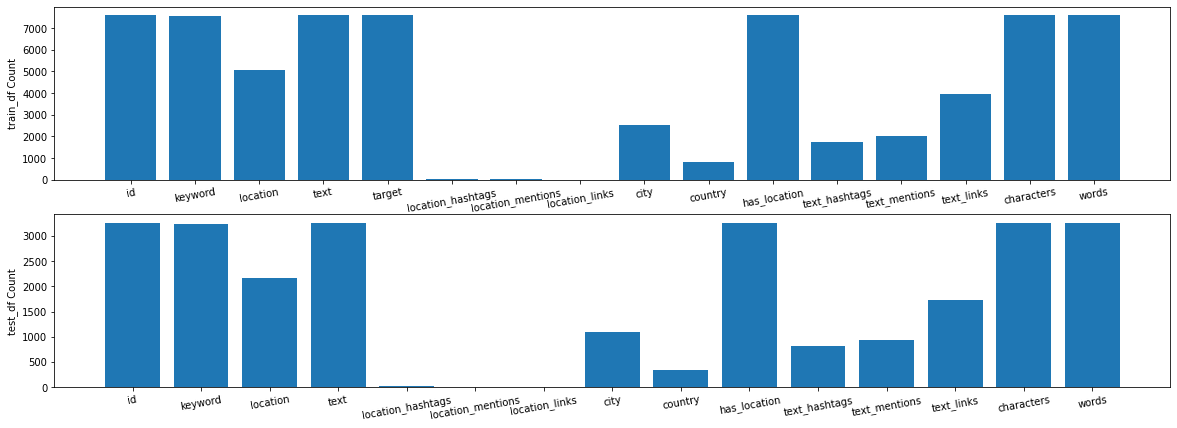

In [18]:
# Get counts
train_feature_counts = train_df.count()
test_feature_counts = test_df.count()

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 7))

# train_df
axs[0].set_ylabel('train_df Count')
axs[0].bar(train_feature_counts.keys(), train_feature_counts.values)

# test_df
axs[1].set_ylabel('test_df Count')
axs[1].bar(test_feature_counts.keys(), test_feature_counts.values)

# Rotate axis
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation = 10)

plt.show()

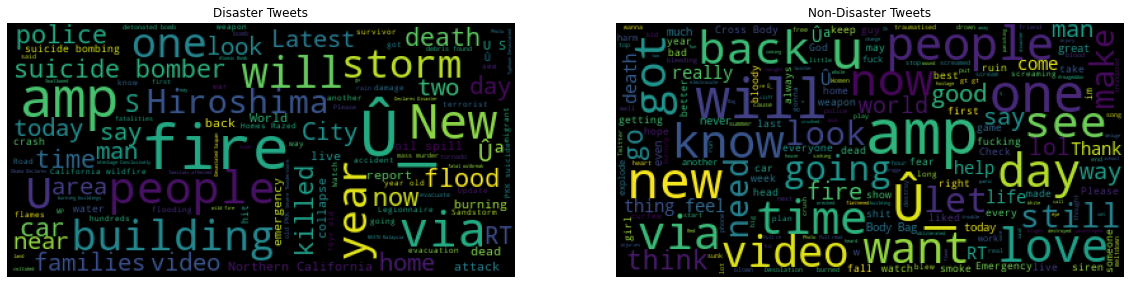

In [19]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 7))

# Disaster Tweets
word_cloud = WordCloud(max_font_size = 50)
word_cloud.generate(" ".join(train_df.loc[train_df['target'] == 1, 'text']))
axs[0].imshow(word_cloud)
axs[0].set_title("Disaster Tweets")
axs[0].axis('off')

# Normal Tweets
word_cloud = WordCloud(max_font_size = 50)
word_cloud.generate(" ".join(train_df.loc[train_df['target'] == 0, 'text']))
axs[1].set_title("Non-Disaster Tweets")
axs[1].imshow(word_cloud)
axs[1].axis('off')

plt.show()

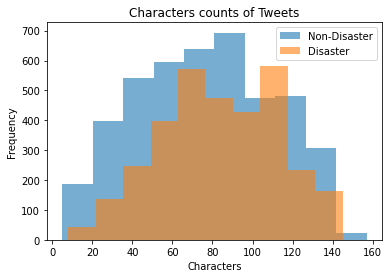

In [20]:
# Analyze the numeber of characters
plt.hist(train_df.loc[train_df['target'] == 0, 'characters'], label = "Non-Disaster", alpha = 0.6)
plt.hist(train_df.loc[train_df['target'] == 1, 'characters'], label = "Disaster", alpha = 0.6)

plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.title('Characters counts of Tweets')
plt.legend()
plt.show()

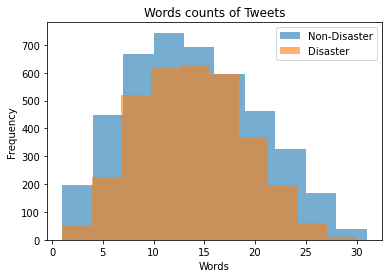

In [21]:
# Analyze the numeber of words
plt.hist(train_df.loc[train_df['target'] == 0, 'words'], label = "Non-Disaster", alpha = 0.6)
plt.hist(train_df.loc[train_df['target'] == 1, 'words'], label = "Disaster", alpha = 0.6)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title('Words counts of Tweets')
plt.legend()
plt.show()

#### 2.4.3.Text Engineering (Pre-processing)
An important step is to patchup the **text** feature. There are a lot of pre-processings we could do; However, not all guarantee a better performance. For instance converting all items to lower-case might not be very good for GloVe. There are many simular cases. However, I'm going to do the followings:

1. Remove all non-ASCII characters.
2. Remove all HTML tags.
3. Remove all numbers.
4. Remove all emojies.
5. Convert all words to lowercase. (We will loose some textual features and gain some other, depends on the model and what you are trying to achive)
6. Remove all stopwords. (Stopwords don't provide much information)
7. Remove all punctuations.
8. Lemmatize all words. (This helps reduce size of the model) (Must be one of the last steps since it takes time to complete)
9. Remove words with too few characters (Default: 2)

Experiments:
- Re-add *#hashtags* back to the text or not remove them in the first place.
- Scrape links to gain extra information about the dataset.

In [22]:
for i, df in enumerate(combined):
    
    text = df['text']

    # Remove non-ASCII characters
    text = text.apply(remove_non_ascii)
    
    # Remove HTML tags
    text = text.apply(remove_html)
    
    # Remove numbers
    text = text.apply(remove_numbers)    
    
    # Remove Emojies
    text = text.apply(remove_emojis)
    
    # Convert to lowercase
    text = text.apply(to_lower)
    
    # Remove stopwords
    text = text.apply(remove_stopwords)
    
    # Remove punctuations
    text = text.apply(remove_punctuation)

    # Lemmatize text
    text = text.apply(lemmatize_text)

    # Remove words with few characters    
    text = text.apply(filter_words)

    df['clean_text'] = text

    # Log
    print(f'{i + 1}th dataset pre-processing complete.')

1th dataset pre-processing complete.
2th dataset pre-processing complete.


## 3.Feature Selection
- *@mentions* don't provide much information as they are simply usernames (which can be literally anything), so I'lll drop them.
- *:links* can be quite useful, but for **location** we have less than 5 total, so let's not risk and remove **location_links** as well.
- Since I don't like the **location** feature (I don't know how it's made and where it comes from?) I don't trust the *#hashtags* it gave us and I'm going to risk dropping them.
- Now that we have extracted as much information as we could from **location**, it's no use for us and it's better be removed.
- We don't have any missing data, but JIC, I'm going to fill the imaginary NAs with "?"
- I'm going to seperate the dataframes into two. It can be a potentially good idea to make two models and ensemble them for the final prediction:
    - text_df: Contains all the text-related features (**text**, **clean_text**).
    - info_df: Contains all other relevant features.

In [23]:
for df in combined:
    
    # Drop features
    df.drop(columns = ['text_mentions', 'location_mentions', 'location_links', 'location', 'location_hashtags'], inplace = True)
    
    # Fill NAs
    df['clean_text'].fillna('?', inplace = True)
    
    # Shuffle
    df = df.sample(frac = 1).reset_index(drop = True)

In [79]:
# Create text_df
train_text_df = train_df[['id', 'text', 'clean_text', 'target']].copy()
test_text_df = test_df[['id', 'text', 'clean_text']].copy()

# Create info_df
train_info_df = train_df[['id', 'keyword', 'city', 'country', 'has_location', 'text_hashtags', 'text_links', 'characters', 'words', 'target']].copy()
test_info_df = test_df[['id', 'keyword', 'city', 'country', 'has_location', 'text_hashtags', 'text_links', 'characters', 'words']].copy()

## 4.Developing the Model(s)

In [80]:
X_train = train_text_df['clean_text']
y_train = train_text_df['target']

X_test = test_text_df['clean_text']

### 4.1.Text Model

In [81]:
tokenizer = Tokenizer(oov_token = '?')
tokenizer.fit_on_texts(X_train)

# Modes: 'binary', 'count', 'freq', 'tfidf'
X_train_encodes = tokenizer.texts_to_matrix(X_train, mode = 'binary')
X_test_encodes = tokenizer.texts_to_matrix(X_test, mode = 'binary')

print('Matrix shape:', X_train_encodes.shape)

Matrix shape: (7613, 10736)


In [82]:
print('Sentences count:', tokenizer.document_count)
print('Top 5 words that are most frequent among vocabulary:', sorted(tokenizer.word_counts.items(), key = lambda x: x[1], reverse = True)[:5])
print('Top 5 words that are most frequent among sentences:', sorted(tokenizer.word_docs.items(), key = lambda x: x[1], reverse = True)[:5])

Sentences count: 7613
Top 5 words that are most frequent among vocabulary: [('like', 393), ('fire', 358), ('amp', 300), ('new', 232), ('get', 211)]
Top 5 words that are most frequent among sentences: [('like', 375), ('fire', 329), ('amp', 270), ('new', 225), ('get', 200)]


#### 4.3.1.Building the Model

In [83]:
def build_model(x, loss, optimizer, metrics):
    model = Sequential()
    model.add(Dense(units = 64, input_shape = (x.shape[1],), activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

    return model

#### 4.3.2.Training the Model

In [84]:
def train_model(model, x, y, epochs, batch_size, validation_split):
    history = model.fit(
    x = x,
    y = y,
    epochs = epochs,
    batch_size = batch_size,
    validation_split = validation_split
    )

    return history.history

#### 4.3.3.Plotting the Model

In [85]:
def plot_model_training(epochs, history, metrics):    

    def plot_subplot(axs, metric, val_metric):
        ''' Plot a single subplot '''

        axs.set_title('Analysis of ' + metric)
        axs.plot(epochs, history[metric], label = metric)
        axs.plot(epochs, history[val_metric], label = val_metric)
        axs.legend()

    fig, axs = plt.subplots(1, len(metrics), figsize = (18, 5))

    for i, metric in enumerate(metrics):
        plot_subplot(axs[i], metric, 'val_' + metric)

#### 4.3.4.All In One

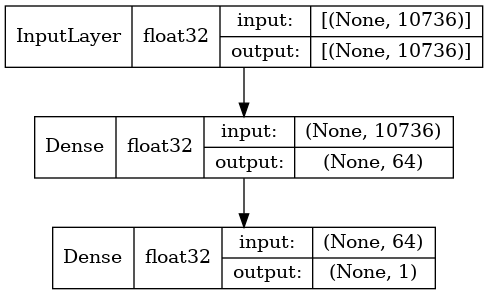

In [86]:
# Build model
model = build_model(
  x = X_train_encodes,
  loss = 'binary_crossentropy',
  optimizer = 'adam',
  metrics = ['accuracy']
)

# Plot model
plot_model(model = model, show_dtype = True, show_shapes = True, show_layer_names = False)

96/96 [==============================] - 2s 12ms/step - loss: 0.6442 - accuracy: 0.6730 - val_loss: 0.5323 - val_accuracy: 0.7912


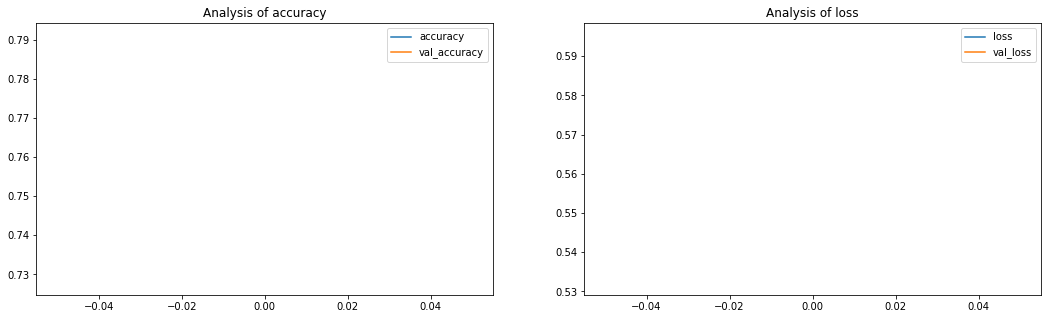

In [87]:
# Train model
history = train_model(
  model = model,
  x = X_train_encodes,
  y = y_train,
  epochs = 1,
  batch_size = 64,
  validation_split = 0.2
)

# Plot training process
epochs = [i for i in range(len(history['loss']))]
plot_model_training(
  epochs = epochs,
  history = history,
  metrics = ['accuracy', 'loss']
)

#### 4.3.5.Making a Prediction

In [88]:
pred = model.predict(X_test_encodes, verbose = 2)
pred = np.round(pred).astype(int).reshape(pred.shape[0])

# Create a submission
submission = pd.DataFrame({'id': test_text_df['id'], 'target': pred})
submission.to_csv('./submission.csv', index = False)

102/102 - 0s
